<a href="https://colab.research.google.com/github/wenxuan0923/My-notes/blob/master/scale_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Scaling in scikit-learn


In this note I will compare the following 5 feature scaling methods though visualization: 

- StandardScaler

- MinMaxScaler

- RobustScaler

- Normalizer

- PowerTransformer


**Standardization (StandardScaler)** standardize features by removing the mean and scaling to unit variance. <br><br>

$$x' = \frac{x-\bar{x}}{\sigma}$$
<br>
Many machine learning estimators may behave badly if the individual features do not more or less look like standard normally distributed data. For instance, many elements used in the objective function of a learning algorithm assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. 


**Normalization (Min-Max Scaling)** scales features to a fixed range - usually 0 to 1. It is often used as an alternative to zero mean, unit variance scaling. Because of this imposed bounded range, the effect of outliers will be suppressed.
<br><br>
$$x'=\frac{x-x_{min}}{x_{max}-x_{min}}$$
<br>

The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data.


**RobustScaler** is a drop-in replacements of normalization when scaling data with outliers. It use more robust estimates for the center and range of data: median value $\tilde{x}$ and the interquartile range, distance between $Q_3$: the 3rd quartile (75th quantile) and $Q_1$: the 1st quartile (25th quantile), to scale the data, which make it robust to outliers. <br><br>
$$x' = \frac{x-\tilde{x}}{Q_{3}-Q_{1}}$$
<br>


**Normalizer** scales individual samples (i.e. each row of the data matrix) to have unit norm. This process can be useful if you plan to use a quadratic form such as the dot-product or any other kernel to quantify the similarity of any pair of samples. For instance, the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors of texts.
<br><br>
$$x' = \frac{x}{||x||}$$
<br>
Note the $x$ here represent individual sample consists of multiple features. Scaling inputs to unit norms is a common operation for text classification or clustering for instance. 
<br>

**PowerTransformer** map data from any distribution to as close to a Gaussian distribution as possible in order to stabilize variance and minimize skewness. Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. 

<center><img src='https://drive.google.com/uc?id=1F2ecuP-I5x5WqKiuFwKiVcIz-Jfrvh64' width=740></img></center>

Note Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.



### Why scale the data?


Many estimators are designed with the assumption that each feature takes values close to zero or more importantly that all features vary on comparable scales. In particular, **metric-based** and **gradient-based** estimators often assume approximately standardized data (centered features with unit variances). A notable exception are decision **tree-based** estimators that are robust to arbitrary scaling of the data. Here are more concrete examples:

- When you are using **distance based models** which compare similarities between data base on some distance measure, it's important to make sure all features have the same scale. For examples: K-nearest neighbors, K-Means Clustering, Over-Sampling method (SMOTE)... 

- When using algorithms that assumes **zero centric data** like Principal Component Analysis(PCA) and try to get the features with maximum variance (note without feature scaling, the high magnitude features will always have the highest variance), it's important to use **Standardization** to scale the data.

- When **gradient descent** is being used to train the model, unscaled data can slow down or even prevent the convergence of many estimators. For example: regularized linear and logistic regression, deep neural network.

Now let's see how these transformation gonna affect the dataset through visualization.






## California housing price data

I will only look into two features and target variable to make visualization easier.

- Feature 0: median income has a long tail distribution

- Feature 5：number of households has a few but very large outliers

References: <a target='_blank' href='https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#normalizer'>Compare the effect of different scalers on data with outliers</a>.

In [0]:
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
cmap = sns.diverging_palette(220, 20, n=7, as_cmap=True)
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler,minmax_scale, 
                                   RobustScaler, Normalizer,
                                   PowerTransformer)
from sklearn import datasets

In [0]:
dataset = datasets.fetch_california_housing()
X_full, y_full = dataset.data, dataset.target
X = X_full[:, [0, 5]]
# scale the target variable between 0 and 1 for the colorbar
y = minmax_scale(y_full)

In [0]:
def create_axes(title, figsize=(14, 6)):
    # set up axes for two scatter plots & histograms and colorbar
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=18)

    # define the axis for the first plot
    left, bottom, width, height = 0.1, 0.1, 0.3, 0.7
    histx_space, histy_space = 0.05, 0.02
    histx_height, histy_width = 0.1, 0.05

    ax_scatter = plt.axes([left, bottom, width, height])
    ax_histx = plt.axes([left, bottom+height+histx_space, width, histx_height])
    ax_histy = plt.axes([left+width+histy_space, bottom, histy_width, height])

    # define the axis for the zoomed-in plot
    left = left + width + left + 0.1

    ax_scatter_zoom = plt.axes([left, bottom, width, height])
    ax_histx_zoom = plt.axes([left, bottom+height+histx_space, width, histx_height])
    ax_histy_zoom = plt.axes([left+width+histy_space, bottom, histy_width, height])

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)

In [0]:
def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="Median Income", 
                      x1_label="Number of Households"):
  
    ax, hist_X1, hist_X0 = axes
    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    ax.scatter(X[:, 0], X[:, 1], 
               alpha=0.9, marker='o', c=y,
               cmap=cmap, s=13, lw=0)

    # Removing the top and the right spine for aesthetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Move ticks and ticklables to the bottom/left of the axes
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    # Set the position of the spine (position type, amount)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, 
                 orientation='horizontal',
                 color='lightslategrey')
    hist_X1.axis('off')

    # Histogram for axis X0 
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, 
                 orientation='vertical',
                 color='lightslategrey')
    hist_X0.axis('off')

In [0]:
def make_plot(title, X, y):
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    
    # distribution of full data
    plot_distribution(ax_zoom_out, X, y, hist_nbins=200,
                      title="Full data")

    # zoom-in (remove the outliers)
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)
    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1)) 
    
    plot_distribution(ax_zoom_in, X[non_outliers_mask], 
                      y[non_outliers_mask],
                      hist_nbins=50, title="Zoom-in")
    # colorbar
    norm = mpl.colors.Normalize(y.min(), y.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Color mapping of housing price')

In [0]:
# try different feature scaling approaches
distributions = {
    'Unscaled data': X,
    'Data after StandardScaler': 
      StandardScaler().fit_transform(X),
    'Data after MinMaxScaler': 
      MinMaxScaler().fit_transform(X),
    'Data after RobustScaler': 
      RobustScaler(quantile_range=(25, 75)).fit_transform(X),
    'Data after PowerTransformer (Yeo-Johnson)': 
      PowerTransformer(method='yeo-johnson').fit_transform(X),
    'Data after PowerTransformer (Box-Cox)': 
      PowerTransformer(method='box-cox').fit_transform(X+1),
    'Data after L2 Normalizer':
      Normalizer().fit_transform(X)
}

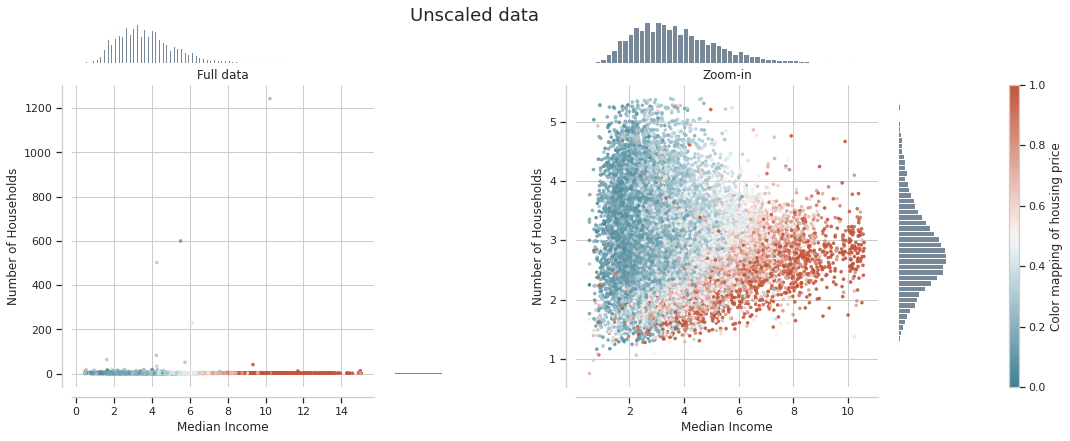

In [7]:
title = 'Unscaled data'
make_plot(title, distributions[title], y)

This first set of plots shows the unscaled data. From the scatter plot of full data left, we can clearly see some strange outliers (over 200 households) there. Therefore, we have another view of the data with those marginal outliers (value larger than 99 percentile) removed (the right plot), and the colorbar represent the value range of target variable: housing price.

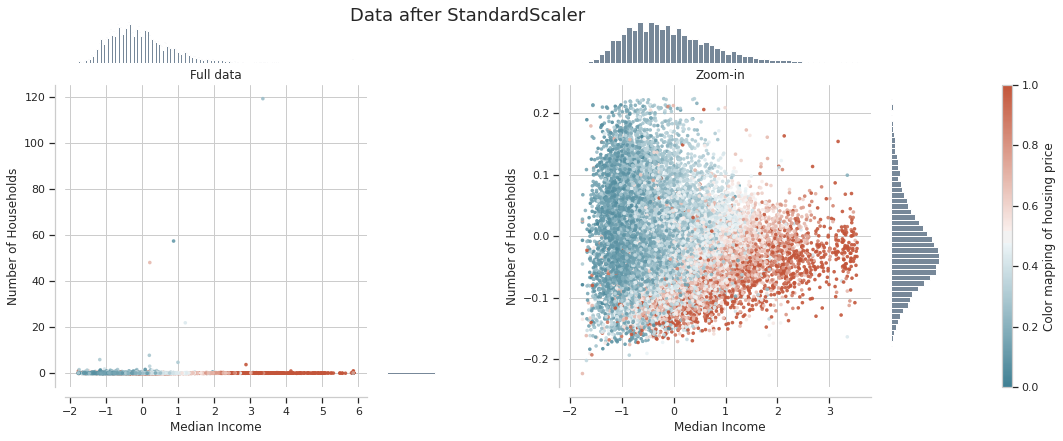

In [10]:
title = 'Data after StandardScaler'
make_plot(title, distributions[title], y)

**StandardScaler** scales the data to have 0 mean and unit variance. We would expect we'll be seeing these two features have both positive and negative values and center around 0.
However, from the full data plot, we can see that the number of households take only values around 0 expect some large positive outliers.

Note in particular that because the outliers on each feature have different magnitudes, the spread of the transformed data on each feature is very different: most of the data lie in the [-2, 4] range for the transformed median income feature while the same data is squeezed in the smaller [-0.2, 0.2] range for the transformed number of households.

**StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.**

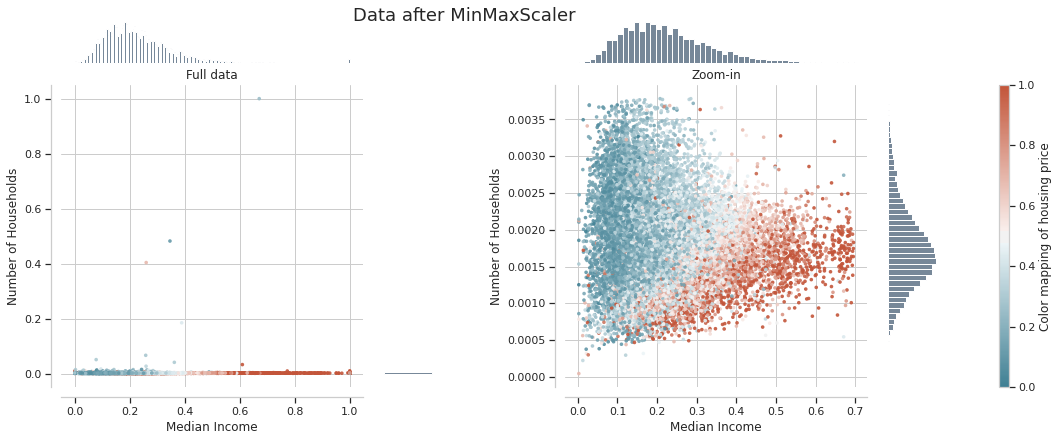

In [11]:
title = 'Data after MinMaxScaler'
make_plot(title, distributions[title], y)

**MinMaxScaler** rescales the data set such that all feature values are in the range [0, 1] as shown in the left panel above. However, after removing the outlier, the number of households are actually in the range [0, 0.004] because of the existence of outliers. 

**As StandardScaler, MinMaxScaler is very sensitive to the presence of outliers.**

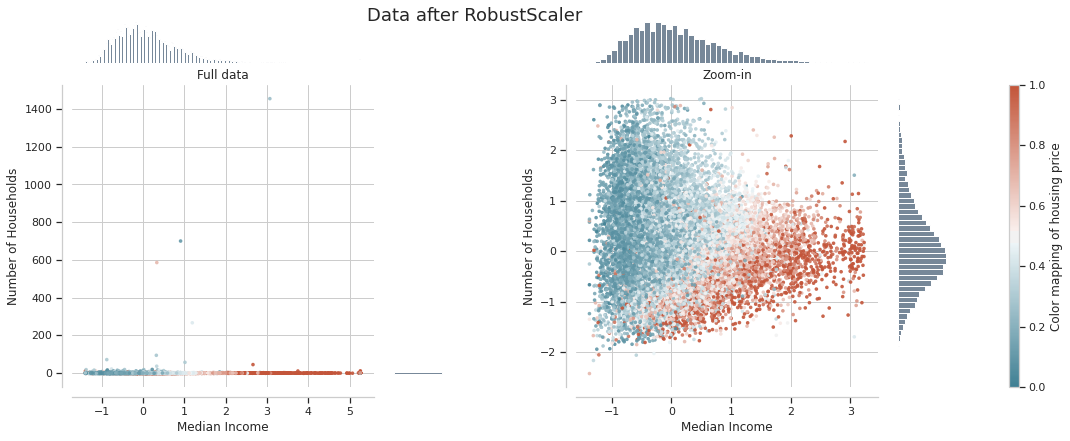

In [12]:
title = 'Data after RobustScaler'
make_plot(title, distributions[title], y)

**Robustscaler** are based on percentiles and are therefore not influenced by outliers. Consequently, the resulting range of the transformed feature values is larger than for the previous scalers and, more importantly, are approximately similar: for both features most of the transformed values lie in a [-2, 3] range as seen in the zoomed-in figure. Note that the **outliers themselves are still present** in the transformed data.

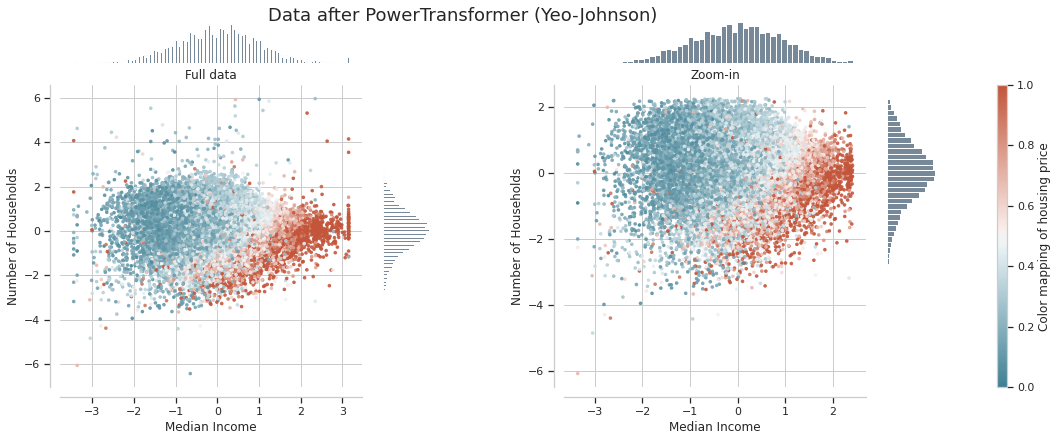

In [13]:
title = 'Data after PowerTransformer (Yeo-Johnson)'
make_plot(title, distributions[title], y)

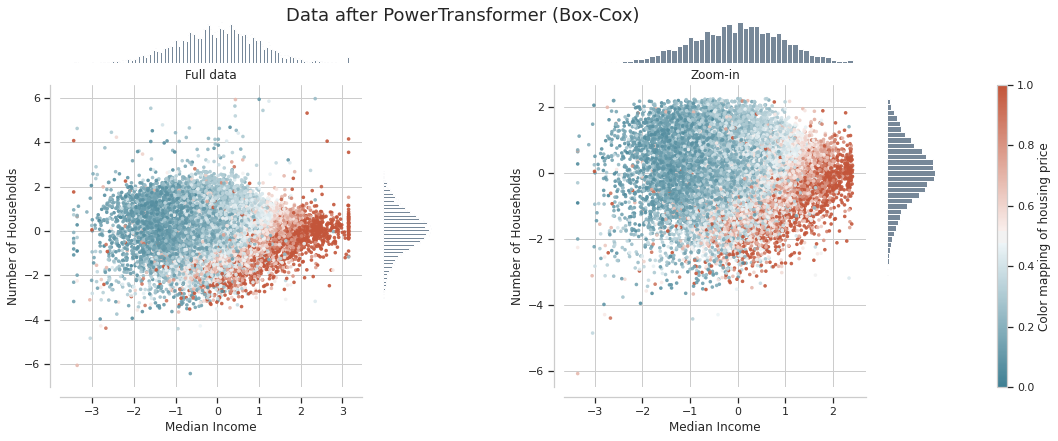

In [14]:
title = 'Data after PowerTransformer (Box-Cox)'
make_plot(title, distributions[title], y)

**PowerTransformer** aim to map data from any distribution to as close to a Gaussian distribution as possible in order to stabilize variance and minimize skewness. It will also apply zero-mean, unit-variance normalization to the transformed output by default. After PowerTransformer, the outliers become barely recognizable. 

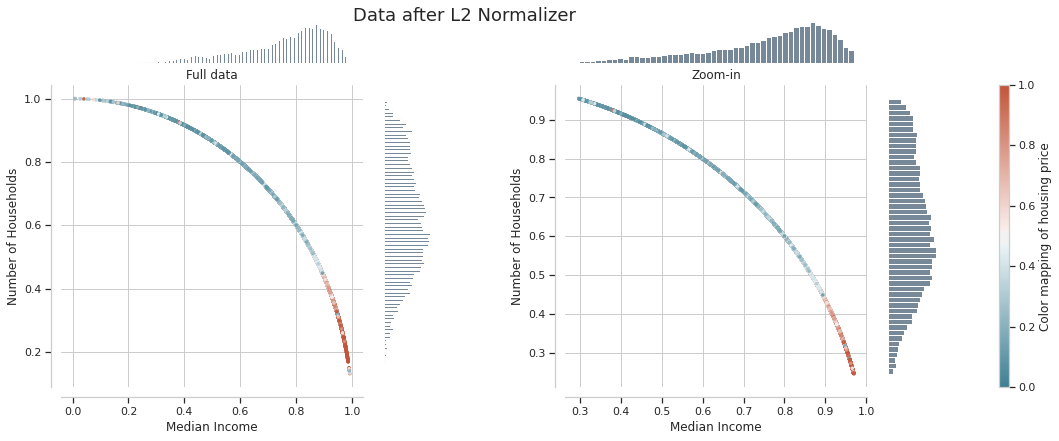

In [15]:
title = 'Data after L2 Normalizer'
make_plot(title, distributions[title], y)

The **Normalizer** rescales each sample to have unit norm, from the plot we casn see all samples have been mapped onto the unit circle.

**Useful References**

<a target='_blank' href='https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler'>Scilit-learn documentation 6.3 Preprocessing data</a>